말이랑 사람 구별하는 모델을 만들어보자!

In [1]:
import urllib.request
import zipfile

url = "https://storage.googleapis.com/download.tensorflow.org/data/horse-or-human.zip"
file_name = "horse-or-human.zip"
training_dir = 'horse-or-human/training/'
urllib.request.urlretrieve(url, file_name) # url을 활용한 데이터 다운로드

zip_ref = zipfile.ZipFile(file_name, 'r')
zip_ref.extractall(training_dir)

validation_url = "https://storage.googleapis.com/download.tensorflow.org/data/validation-horse-or-human.zip"

validation_file_name = "validation-horse-or-human.zip"
validation_dir = 'horse-or-human/validation/'
urllib.request.urlretrieve(validation_url, validation_file_name)

zip_ref = zipfile.ZipFile(validation_file_name, 'r')
zip_ref.extractall(validation_dir)
zip_ref.close()

In [2]:
# augmentation하면서 폴더째로 데이터 가져와보기 (directory통해서 가지고 오는 것!! 현업에서는 이렇게 많이함!!)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

train_datagen = ImageDataGenerator(
    rescale=1./255,       # normalization(정규화) / 이미지 불러오면서 정규화까지 해주겠다!
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data = train_datagen.flow_from_directory(     # 이미지 처리할때 이렇게 많이 함! 폴더째로 통째로 가져올때!! 이부분 잘보기!
    training_dir,     # /content/horse-or-human/training (이렇게 경로 직접 넣어줘도 되지만 이렇게 변수명 위에서 선언해주는게 깔끔!)
    target_size = (300,300), # 이미지 사이즈
    class_mode = 'binary' # 이진 분류
)

validation_datagen = ImageDataGenerator(   #data augmentation을 안함! 얘는 실제 test 하기 전에.. 검증하는거니까!!
    rescale=1./255,      
)

validation_data = train_datagen.flow_from_directory(     # 이미지 처리할때 이렇게 많이 함! 폴더째로 통째로 가져올때!! 이부분 잘보기!
    validation_dir,
    target_size = (300,300), # 이미지 사이즈
    class_mode = 'binary' # 이진 분류
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [3]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', 
                           input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') # class가 2개인데 1로 될까. 이진분류라서 0아니면 1이됨. 말이0이고, 사람이1이면, 1에 가까울수록 사람일거임(0.8d이라면 사람..) >> 이진분류일때는 sigmoid쓰고, 1개가 아웃풋으로 나온다!
])

In [4]:
model.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.experimental.RMSprop(),
              metrics = ['accuracy'])

In [5]:
model.fit(train_data, epochs = 5, validation_data = validation_data) # gpu의 필요성.. 왜 이렇게 시간이 비용이라는지.. (컬러이미지&input_size 큼)

Epoch 1/5
33/33 [==============================] - 47s 1s/step - loss: 0.8747 - accuracy: 0.5326 - val_loss: 0.7011 - val_accuracy: 0.5000
Epoch 2/5
33/33 [==============================] - 30s 927ms/step - loss: 0.7652 - accuracy: 0.6553 - val_loss: 0.7564 - val_accuracy: 0.5312
Epoch 3/5
33/33 [==============================] - 35s 1s/step - loss: 0.6161 - accuracy: 0.6904 - val_loss: 0.7140 - val_accuracy: 0.5000
Epoch 4/5
33/33 [==============================] - 35s 1s/step - loss: 0.5335 - accuracy: 0.7332 - val_loss: 0.8913 - val_accuracy: 0.5156
Epoch 5/5
33/33 [==============================] - 38s 1s/step - loss: 0.4993 - accuracy: 0.7614 - val_loss: 1.3126 - val_accuracy: 0.5234


- case2 해보자!

In [6]:
# 프리트레인된 모델을 가져왔다! (모델 구성과 웨이트를)
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3 # 이 모델을 불러옴
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout
weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "inception_v3.h5"
urllib.request.urlretrieve(weights_url, weights_file) # weight 파일도 가져옴!
pre_trained_model = InceptionV3(input_shape=(300, 300, 3),
                                include_top=False,
                                weights=None)
pre_trained_model.load_weights(weights_file)

In [7]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d_5[0][0]']               
 alization)                     )                                                      

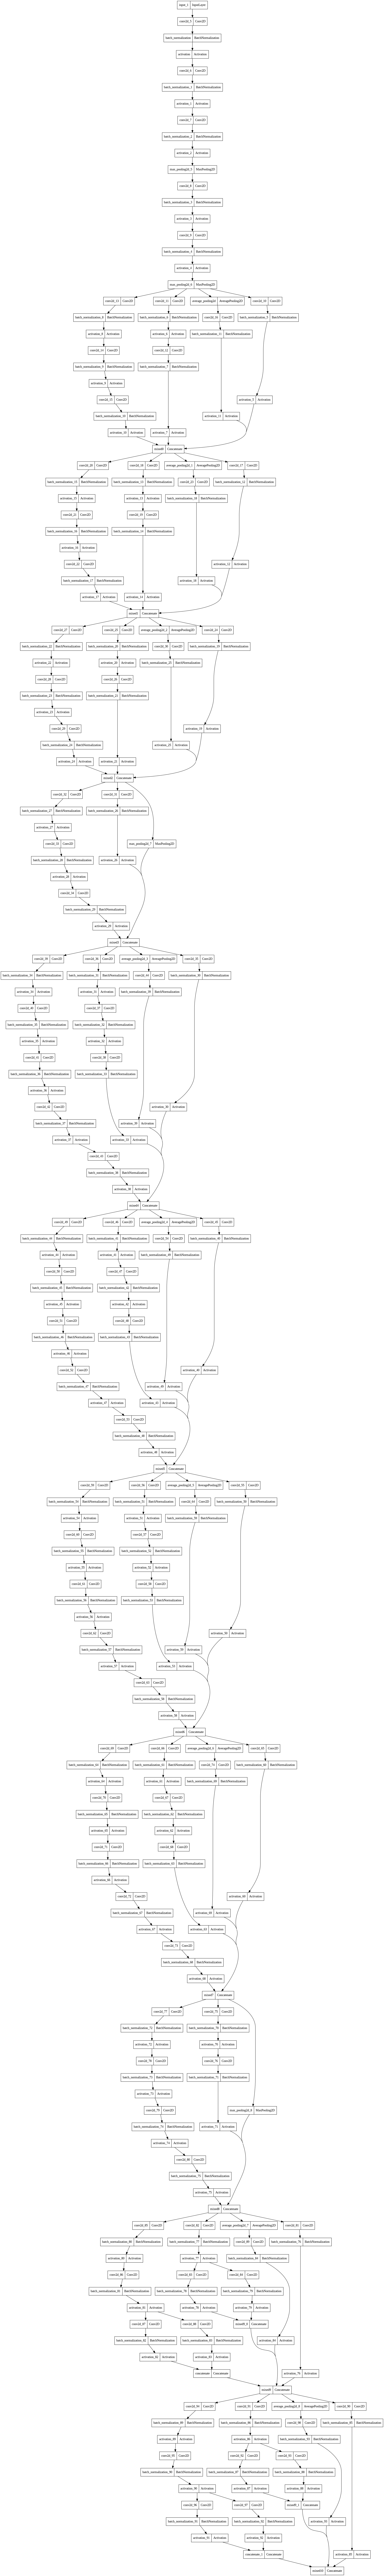

In [9]:
tf.keras.utils.plot_model(pre_trained_model, 'model.png') # png로 plot되서 파일로 저장됨! 크게 보고 싶으면 그 파일 열어서 보면됨.

- 어디서 자르고 붙이는게 좋을지.. 살펴보면 어느정도 안다! 여러군데 일수도 있음!
- 모이는데 기준으로 자르면 됨! 뭉탱이 기준!

In [11]:
# 전이학습하기 위해서 freeze

# for layer in pre_trained_model.layers:
#   layer.trainable = False
pre_trained_model.trainable = False # 모든 레이어할때는 이렇게 하면 됨

# 모델의 마지막 layer만 가져옴
last_layer = pre_trained_model.get_layer('mixed10') # 처음부터 10까지 다 가져오는거! 하나만 가지고 온게 아니라 앞에것까지 다 가져온거임!
# 그 layer의 output만 가져옴 > 앞부분, 뒷부분 붙여주기. 붙여주기 위해서 마지막 아웃풋 출력해줫.. 즉 도입부분을 찍어줘서 잘 연결되게끔 수정, 변형해줌
# 앞에 pre_trained_model의 앞에 트레인된 정보를 가져온다는건 아님!!!!(앞에 학습된걸 가져오는게 아님!)
last_output = last_layer.output 
last_output # shape=(None, 8, 8, 2048) >> 피처맵이 이렇게 있는거임 >> flatten부터 가져와야 됨!

<KerasTensor: shape=(None, 8, 8, 2048) dtype=float32 (created by layer 'mixed10')>

In [13]:
# funtional하게 모델 만드는 방법(구성하는) 중 하나! 모델 만드는 방식중에 하나!
# pre_trained_model 뒤에 붙일 layer
x = layers.Flatten()(last_output) # pre_trained_model의 output을 input으로 해서 시작하는 거임!!
x = layers.Dense(1024, activation = 'relu')(x) 
x = layers.Dense(1, activation = 'sigmoid')(x)

In [15]:
# 최종적으로 model 만들기
model = Model(pre_trained_model.input, x) #  Model이라는 객체 만들어주고, 넣어주면 됨!

# compile하기전에 summary 보기
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d_5[0][0]']               
 alization)                     )                                                           

In [16]:
model.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.experimental.RMSprop(),
              metrics = ['accuracy'])

In [17]:
model.fit(train_data, epochs = 5, validation_data = validation_data)

Epoch 1/5
33/33 [==============================] - 40s 1s/step - loss: 33.0755 - accuracy: 0.9075 - val_loss: 0.4988 - val_accuracy: 0.9883
Epoch 2/5
33/33 [==============================] - 36s 1s/step - loss: 7.4457 - accuracy: 0.9572 - val_loss: 0.3742 - val_accuracy: 0.9961
Epoch 3/5
33/33 [==============================] - 35s 1s/step - loss: 0.6105 - accuracy: 0.9893 - val_loss: 7.2271 - val_accuracy: 0.9375
Epoch 4/5
33/33 [==============================] - 33s 994ms/step - loss: 2.8448 - accuracy: 0.9737 - val_loss: 0.9825 - val_accuracy: 0.9883
Epoch 5/5
33/33 [==============================] - 31s 955ms/step - loss: 0.4776 - accuracy: 0.9961 - val_loss: 0.8317 - val_accuracy: 0.9883


In [ ]:
# 와.. accuracy가 엄청 올랐다.. transfer learning해야되네.. 잘 만들어진거 잘쓰는게 우선은 중요!!